In [1]:
DATABASES = {
    "WindowsLog":"/mnt/d/Data/NLP/WindowsTop10000.log",
}

EMBEDDINGS = {
    "FastText":"/mnt/d/Data/NLP/crawl-300d-2M-subword.bin",
}


In [6]:
#Downloaded from https://fasttext.cc/docs/en/english-vectors.html
#Gensim supports loading fasttext model that can guess words not in dictionary with load_facebook_vectors() - .bin files
#but that model format has to include subword/model info such as crawl-300d-2M-subword.zip
#Alternatively, model that can not guess words not in dictionary can be loaded with KeyedVectors.load_word2vec_format(), such as crawl-300d-2M.vec.zip,
#usually .vec files similarly to GoogleNews above
#Explanation: https://stackoverflow.com/questions/62308418/word-embedding-with-gensim-and-fasttext-training-on-pretrained-vectors

#Loads in cca 6 mins
from gensim import models
fasttext = models.fasttext.load_facebook_vectors(EMBEDDINGS["FastText"])

In [11]:
def split_log(log: str) -> list:
    return log.split()

import re
date_pattern = re.compile(r"\d{4}-\d{2}-\d{2}")
time_pattern = re.compile(r"\d{2}:\d{2}:\d{2},")
tokens = []
with open(DATABASES['WindowsLog'], 'r') as f:
    line = f.readline()
    while line:
        # Process the line
        words = split_log(line)
        filtered_words = [
            w for w in words
            if not (date_pattern.fullmatch(w) or time_pattern.fullmatch(w))
        ]
        tokens.extend(filtered_words)
        line = f.readline()
print(f"Tokens size: {len(tokens)}")
dictionary = list(set(tokens))  # Remove duplicates
print(f"Dictionary size: {len(dictionary)}")

Tokens size: 98945
Dictionary size: 3757


In [ ]:
from concurrent.futures import ThreadPoolExecutor
import numpy as np
n = len(dictionary)
distances = np.zeros((n, n))

def compute_distances(i, dictionary, distances, n):
    for j in range(i, n):
        dist = fasttext.distance(dictionary[i], dictionary[j])
        distances[i, j] = dist
        distances[j, i] = dist  # Symmetric

with ThreadPoolExecutor(12) as executor:
    for i in range(n):
        executor.submit(compute_distances, i, dictionary, distances, n)

# Save the distances to a file
np.save('./output/distances.npy', distances)
# Save the dictionary to a file
with open('./output/dictionary.txt', 'w') as f:
    for word in dictionary:
        f.write(f"{word}\n")

In [2]:
# Load the distances and dictionary from files
import numpy as np
distances_loaded = np.load('./output/distances.npy')
with open('./output/dictionary.txt', 'r') as f:
    dictionary_loaded = [line.strip() for line in f]

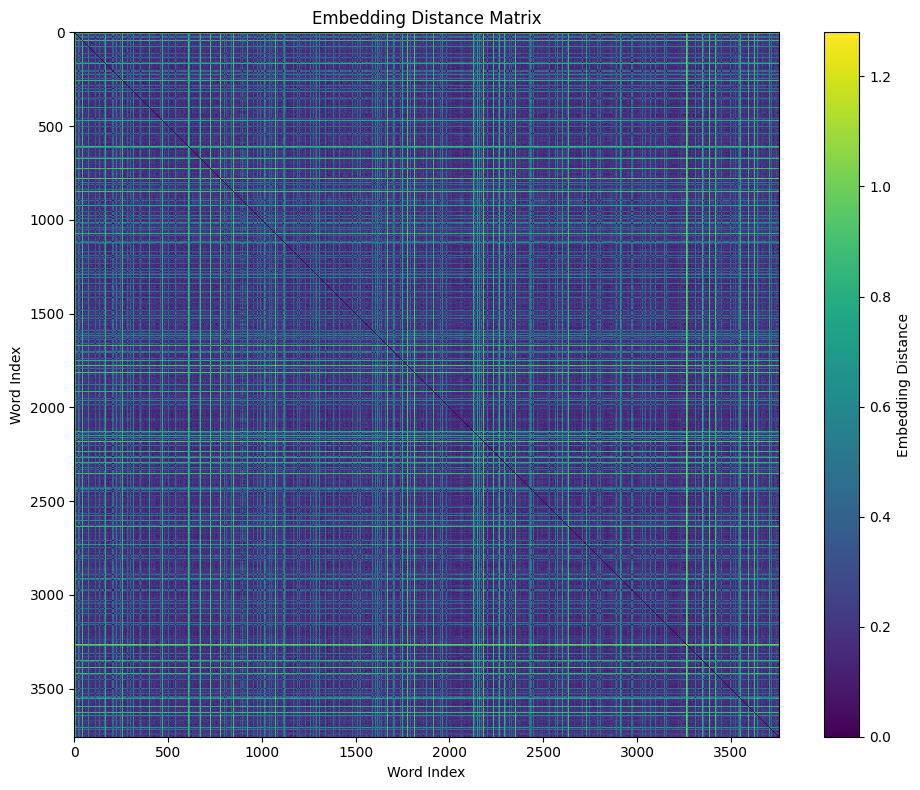

In [16]:
import numpy as np
import matplotlib.pyplot as plt
distances_array = np.array(distances)
plt.figure(figsize=(10, 8))
plt.imshow(distances_array, cmap='viridis', interpolation='nearest')
plt.colorbar(label='Embedding Distance')
plt.title('Embedding Distance Matrix')
plt.xlabel('Word Index')
plt.ylabel('Word Index')
plt.tight_layout()
plt.show()